This is the colab notebook of the ShapeMatchingGAN model that Henry and I made for our final of Allison's [Material of Language](https://mol.decontextualize.com/) class. It is capable of using a photo to style a glyph composition. It uses what we've done with the GlyphGAN model - a generated glyph compostion about waterfall, and applied an actual waterfall style to the generated composition.

The code is heavily based on this repo: https://github.com/TAMU-VITA/ShapeMatchingGAN

The model consists of three networks: a sketch network to extract the sketchy structure of glyphs in an image, plus a structure and a texture model that can style the glypgs with an input style image. 

# Getting Started
First clone the repo, and download the augment dataset.

In [0]:
!git clone -l -s https://github.com/TAMU-VITA/ShapeMatchingGAN.git

Cloning into 'ShapeMatchingGAN'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 603 (delta 1), reused 3 (delta 0), pack-reused 592
Receiving objects: 100% (603/603), 6.22 MiB | 9.04 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [0]:
cd /content/ShapeMatchingGAN/

/content/ShapeMatchingGAN


In [0]:
!gdown 'https://drive.google.com/uc?id=1gjHR39deUSPChtRbKAD80waoQFTiXyMs'

Downloading...
From: https://drive.google.com/uc?id=1gjHR39deUSPChtRbKAD80waoQFTiXyMs
To: /content/ShapeMatchingGAN/ShapeMGAN-data_plus_model.zip
118MB [00:02, 46.9MB/s]


In [0]:
!unzip ShapeMGAN-data_plus_model.zip

Archive:  ShapeMGAN-data_plus_model.zip
   creating: data/rawtext/augment/
  inflating: data/rawtext/augment/0000.png  
  inflating: data/rawtext/augment/0001.png  
  inflating: data/rawtext/augment/0002.png  
  inflating: data/rawtext/augment/0003.png  
  inflating: data/rawtext/augment/0004.png  
   creating: data/rawtext/yaheiB/train/
  inflating: data/rawtext/yaheiB/train/0000.png  
  inflating: data/rawtext/yaheiB/train/0001.png  
  inflating: data/rawtext/yaheiB/train/0002.png  
  inflating: data/rawtext/yaheiB/train/0003.png  
  inflating: data/rawtext/yaheiB/train/0004.png  
  inflating: data/rawtext/yaheiB/train/0005.png  
  inflating: data/rawtext/yaheiB/train/0006.png  
  inflating: data/rawtext/yaheiB/train/0007.png  
  inflating: data/rawtext/yaheiB/train/0008.png  
  inflating: data/rawtext/yaheiB/train/0009.png  
  inflating: data/rawtext/yaheiB/train/0010.png  
  inflating: data/rawtext/yaheiB/train/0011.png  
  inflating: data/rawtext/yaheiB/train/0012.png  
  inflatin

# Sketch
Define the Sketch model and train it with preprocessed glyph images in data/rawtext.

In [0]:
cd /content/ShapeMatchingGAN/src

/content/ShapeMatchingGAN/src


In [0]:
from __future__ import print_function
import torch
from models import SketchModule
from utils import load_image, to_data, to_var, visualize, save_image, gaussian, weights_init
from utils import load_train_batchfnames, prepare_text_batch
import argparse
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

opts = argparse.ArgumentParser()
opts.GB_nlayers = 6
opts.DB_nlayers = 5
opts.GB_nf = 32
opts.DB_nf = 32
opts.gpu = True
opts.epochs = 3
opts.save_GB_name = '../save/GB.ckpt'
opts.batchsize = 16
opts.text_path = '../data/rawtext/yaheiB/train'
opts.augment_text_path = '../data/rawtext/augment'
opts.text_datasize = 708
opts.augment_text_datasize = 5
opts.Btraining_num = 12800


In [0]:
# create model
print('--- create model ---')
netSketch = SketchModule(opts.GB_nlayers, opts.DB_nlayers, opts.GB_nf, opts.DB_nf, opts.gpu)
if opts.gpu:
    netSketch.cuda()
netSketch.init_networks(weights_init)
netSketch.train()

--- create model ---


SketchModule(
  (loss): L1Loss()
  (transBlock): SketchGenerator(
    (encoder): Sequential(
      (0): Conv2d(4, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (1): ReLU()
      (2): mySConv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): ReLU()
      )
      (3): mySConv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): ReLU()
      )
    )
    (transformer): Sequential(
      (0): mySBlock(
        (myconv): mySConv(
          (conv): Conv2d(129, 129, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn): InstanceNorm2d(129, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (relu): ReLU()
        )
        (conv): Conv2d(129, 129, kernel

In [0]:
#training
print('--- training ---')
for epoch in range(opts.epochs):
    itr = 0
    fnames = load_train_batchfnames(opts.text_path, opts.batchsize, 
                                    opts.text_datasize, trainnum=opts.Btraining_num)
    fnames2 = load_train_batchfnames(opts.augment_text_path, opts.batchsize, 
                                    opts.augment_text_datasize, trainnum=opts.Btraining_num)
    for ii in range(len(fnames)):
        fnames[ii][0:opts.batchsize/2-1] = fnames2[ii][0:opts.batchsize/2-1]
    for fname in fnames:
        itr += 1
        t = prepare_text_batch(fname, anglejitter=True)
        t = to_var(t) if opts.gpu else t
        losses = netSketch.one_pass(t, [l/4.-1. for l in range(0,9)])      
        print('Epoch [%d/%d][%03d/%03d]' %(epoch+1, opts.epochs,itr,len(fnames)), end=': ')
        print('LDadv: %+.3f, LGadv: %+.3f, Lrec: %+.3f'%(losses[0], losses[1], losses[2]))

print('--- save ---')
# directory
torch.save(netSketch.state_dict(), opts.save_GB_name)

# Prepare Custom Style Image
In order to style our generated composition with waterfall, we prepared a waterfall image, and processed the black and white version of it using the text_image_preprocessing utility to get the distance image. Then we stiched the distance image and the original waterfall image together, and use is as the style image for Structure and Texture training.

In [0]:
cd /content/ShapeMatchingGAN/data

/content/ShapeMatchingGAN/data


In [0]:
!mkdir style_bw

In [0]:
#prepare custom style image
from PIL import Image
from utils import text_image_preprocessing, save_image, load_image

In [0]:
#get distance image, then concat it with original style image in photoshop, then upload back to style folder
style_distance_img = text_image_preprocessing('/content/ShapeMatchingGAN/data/style_bw/waterfall3_bw_small.jpg')
style_distance_img.save('/content/ShapeMatchingGAN/data/style_bw/waterfall3_dist_small.jpg')

# Structure
Here are the model definition and training for the Structure model.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
googledrive_save_path = '/content/gdrive/My Drive/'

In [0]:
cd /content/ShapeMatchingGAN/src/

/content/ShapeMatchingGAN/src


In [0]:
from __future__ import print_function
import torch
from models import SketchModule, ShapeMatchingGAN
from utils import load_image, to_data, to_var, visualize, save_image, gaussian, weights_init
from utils import load_train_batchfnames, prepare_text_batch, load_style_image_pair, cropping_training_batches
import random
import argparse
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

opts = argparse.ArgumentParser()
# SMGAN
opts.GS_nlayers = 6
opts.DS_nlayers = 4
opts.GS_nf = 32
opts.DS_nf = 32
opts.GT_nlayers = 6
opts.DT_nlayers = 4
opts.GT_nf = 32
opts.DT_nf = 32

# SketchModule
opts.GB_nlayers = 6
opts.DB_nlayers = 5
opts.GB_nf = 32
opts.DB_nf = 32
opts.load_GB_name = '../save/GB-iccv.ckpt'

# train 
opts.gpu = True
opts.step1_epochs = 30
opts.step2_epochs = 40
opts.step3_epochs = 80
opts.step4_epochs = 10
opts.batchsize = 16
opts.Straining_num = 2560
opts.scale_num = 4
opts.Sanglejitter = True
opts.subimg_size = 256
opts.glyph_preserve = False
opts.text_datasize = 708
opts.text_path = '../data/rawtext/yaheiB/train'

# data and path
opts.save_path = '../save/'
opts.save_name = 'waterfall'
opts.style_name = '../data/style/waterfall.png'


# create model
print('--- create model ---')
netShapeM = ShapeMatchingGAN(opts.GS_nlayers, opts.DS_nlayers, opts.GS_nf, opts.DS_nf,
                 opts.GT_nlayers, opts.DT_nlayers, opts.GT_nf, opts.DT_nf, opts.gpu)
netSketch = SketchModule(opts.GB_nlayers, opts.DB_nlayers, opts.GB_nf, opts.DB_nf, opts.gpu)

if opts.gpu:
    netShapeM.cuda()
    netSketch.cuda()
netShapeM.init_networks(weights_init)
netShapeM.train()

netSketch.load_state_dict(torch.load(opts.load_GB_name))
netSketch.eval()



--- create model ---


SketchModule(
  (loss): L1Loss()
  (transBlock): SketchGenerator(
    (encoder): Sequential(
      (0): Conv2d(4, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (1): ReLU()
      (2): mySConv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): ReLU()
      )
      (3): mySConv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): ReLU()
      )
    )
    (transformer): Sequential(
      (0): mySBlock(
        (myconv): mySConv(
          (conv): Conv2d(129, 129, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn): InstanceNorm2d(129, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (relu): ReLU()
        )
        (conv): Conv2d(129, 129, kernel

In [0]:
print('--- training ---')
# load image pair
scales = [l*2.0/(opts.scale_num-1)-1 for l in range(opts.scale_num)]
Xl, X, _, Noise = load_style_image_pair(opts.style_name, scales, netSketch, opts.gpu)
Xl = [to_var(a) for a in Xl] if opts.gpu else Xl
X = to_var(X) if opts.gpu else X
Noise = to_var(Noise) if opts.gpu else Noise
for epoch in range(opts.step1_epochs):
    for i in range(opts.Straining_num/opts.batchsize):
        idx = opts.scale_num-1
        xl, x = cropping_training_batches(Xl[idx], X, Noise, opts.batchsize, 
                                  opts.Sanglejitter, opts.subimg_size, opts.subimg_size)
        losses = netShapeM.structure_one_pass(x, xl, scales[idx])
        print('Step1, Epoch [%02d/%02d][%03d/%03d]' %(epoch+1, opts.step1_epochs, i+1, 
                                                      opts.Straining_num/opts.batchsize), end=': ')
        print('LDadv: %+.3f, LGadv: %+.3f, Lrec: %+.3f, Lgly: %+.3f'%(losses[0], losses[1], losses[2], losses[3]))
netShapeM.save_structure_model(googledrive_save_path, opts.save_name + '_Epoch1') # save to drive
netShapeM.G_S.myCopy()
for epoch in range(opts.step2_epochs):
    for i in range(opts.Straining_num/opts.batchsize):
        idx = random.choice([0, opts.scale_num-1])
        xl, x = cropping_training_batches(Xl[idx], X, Noise, opts.batchsize, 
                                  opts.Sanglejitter, opts.subimg_size, opts.subimg_size)
        losses = netShapeM.structure_one_pass(x, xl, scales[idx])
        print('Step2, Epoch [%02d/%02d][%03d/%03d]' %(epoch+1, opts.step2_epochs, i+1, 
                                                      opts.Straining_num/opts.batchsize), end=': ')
        print('LDadv: %+.3f, LGadv: %+.3f, Lrec: %+.3f, Lgly: %+.3f'%(losses[0], losses[1], losses[2], losses[3]))
netShapeM.save_structure_model(googledrive_save_path, opts.save_name + '_Epoch2') # save to drive
for epoch in range(opts.step3_epochs):
    for i in range(opts.Straining_num/opts.batchsize):
        idx = random.choice(range(opts.scale_num))
        xl, x = cropping_training_batches(Xl[idx], X, Noise, opts.batchsize, 
                                  opts.Sanglejitter, opts.subimg_size, opts.subimg_size)
        losses = netShapeM.structure_one_pass(x, xl, scales[idx])  
        print('Step3, Epoch [%02d/%02d][%03d/%03d]' %(epoch+1, opts.step3_epochs, i+1, 
                                                      opts.Straining_num/opts.batchsize), end=': ')
        print('LDadv: %+.3f, LGadv: %+.3f, Lrec: %+.3f, Lgly: %+.3f'%(losses[0], losses[1], losses[2], losses[3]))
netShapeM.save_structure_model(googledrive_save_path, opts.save_name + '_Epoch3') # save to drive
if opts.glyph_preserve:
    fnames = load_train_batchfnames(opts.text_path, opts.batchsize, 
                                    opts.text_datasize, opts.Straining_num)
    for epoch in range(opts.step4_epochs):
        itr = 0
        for fname in fnames:
            itr += 1
            t = prepare_text_batch(fname, anglejitter=False)
            idx = random.choice(range(opts.scale_num))
            xl, x = cropping_training_batches(Xl[idx], X, Noise, opts.batchsize, 
                                      opts.Sanglejitter, opts.subimg_size, opts.subimg_size)
            t = to_var(x) if opts.gpu else t
            losses = netShapeM.structure_one_pass(x, xl, scales[idx], t)  
            print('Step4, Epoch [%02d/%02d][%03d/%03d]' %(epoch+1, opts.step4_epochs, itr+1, 
                                                      len(fnames)), end=': ')
            print('LDadv: %+.3f, LGadv: %+.3f, Lrec: %+.3f, Lgly: %+.3f'%(losses[0], losses[1], losses[2], losses[3])) 
        
print('--- save ---')
# directory
netShapeM.save_structure_model(opts.save_path, opts.save_name)
netShapeM.save_structure_model(googledrive_save_path, opts.save_name) # save to drive

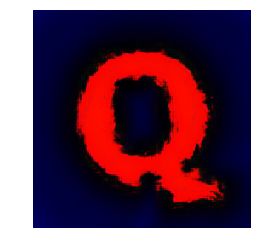

In [0]:
netShapeM.G_S.load_state_dict(torch.load('../save/waterfall-GS.ckpt'))  
netShapeM.eval()
I = load_image('../data/rawtext/yaheiB/val/0801.png')
I = to_var(I[:,:,32:288,32:288])
I[:,0:1] = gaussian(I[:,0:1], stddev=0.2)
result = netShapeM.G_S(I, 1.0)
visualize(to_data(result[0]))

# Texture
Here are the model definition and training for the texture model.

In [0]:
from __future__ import print_function
import torch
from models import SketchModule, ShapeMatchingGAN
from utils import load_image, to_data, to_var, visualize, save_image, gaussian, weights_init
from utils import load_train_batchfnames, prepare_text_batch, load_style_image_pair, cropping_training_batches
import random
from vgg import get_GRAM, VGGFeature
import torchvision.models as models
import argparse
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

opts = argparse.ArgumentParser()
# SMGAN
opts.GS_nlayers = 6
opts.DS_nlayers = 4
opts.GS_nf = 32
opts.DS_nf = 32
opts.GT_nlayers = 6
opts.DT_nlayers = 4
opts.GT_nf = 32
opts.DT_nf = 32

# train 
opts.gpu = True
opts.texture_step1_epochs = 40
opts.texture_step2_epochs = 10
opts.batchsize = 4
opts.Ttraining_num = 800
opts.Tanglejitter = True
opts.subimg_size = 256
opts.style_loss = True
opts.text_path = '../data/rawtext/yaheiB/train'
opts.text_datasize = 708
opts.augment_text_path_path = '../data/rawtext/augment'
opts.augment_text_datasize = 5


# data and path
opts.save_path = '../save/'
opts.save_name = 'waterfall'
opts.style_name = '../data/style/waterfall.png'
opts.load_GS_name = '../save/waterfall-GS.ckpt'

# create model
print('--- create model ---')
netShapeM = ShapeMatchingGAN(opts.GS_nlayers, opts.DS_nlayers, opts.GS_nf, opts.DS_nf,
                 opts.GT_nlayers, opts.DT_nlayers, opts.GT_nf, opts.DT_nf, opts.gpu)

if opts.gpu:
    netShapeM.cuda()
netShapeM.init_networks(weights_init)
netShapeM.train()

if opts.style_loss:
    netShapeM.G_S.load_state_dict(torch.load(opts.load_GS_name))  
    netShapeM.G_S.eval()
    VGGNet = models.vgg19(pretrained=True).features
    VGGfeatures = VGGFeature(VGGNet, opts.gpu)
    for param in VGGfeatures.parameters():
        param.requires_grad = False
    if opts.gpu:
        VGGfeatures.cuda()
    style_targets = get_GRAM(opts.style_name, VGGfeatures, opts.batchsize, opts.gpu)

--- create model ---


In [0]:
print('--- training ---')
# load image pair
_, X, Y, Noise = load_style_image_pair(opts.style_name, gpu=opts.gpu)
Y = to_var(Y) if opts.gpu else Y
X = to_var(X) if opts.gpu else X
Noise = to_var(Noise) if opts.gpu else Noise
for epoch in range(opts.texture_step1_epochs):
    for i in range(opts.Ttraining_num/opts.batchsize):
        x, y = cropping_training_batches(X, Y, Noise, opts.batchsize, 
                                  opts.Tanglejitter, opts.subimg_size, opts.subimg_size)
        losses = netShapeM.texture_one_pass(x, y)
        print('Step1, Epoch [%02d/%02d][%03d/%03d]' %(epoch+1, opts.texture_step1_epochs, i+1,
                                                     opts.Ttraining_num/opts.batchsize), end=': ')
        print('LDadv: %+.3f, LGadv: %+.3f, Lrec: %+.3f, Lsty: %+.3f'%(losses[0], losses[1], losses[2], losses[3])) 
netShapeM.save_texture_model(googledrive_save_path, opts.save_name + '_1')
if opts.style_loss:
    fnames = load_train_batchfnames(opts.text_path, opts.batchsize, 
                                    opts.text_datasize, trainnum=opts.Ttraining_num)
    for epoch in range(opts.texture_step2_epochs):
        itr = 0
        for fname in fnames:
            itr += 1
            t = prepare_text_batch(fname, anglejitter=False)
            x, y = cropping_training_batches(X, Y, Noise, opts.batchsize, 
                                  opts.Tanglejitter, opts.subimg_size, opts.subimg_size)
            t = to_var(t) if opts.gpu else t
            losses = netShapeM.texture_one_pass(x, y, t, 0, VGGfeatures, style_targets)  
            print('Step2, Epoch [%02d/%02d][%03d/%03d]' %(epoch+1, opts.texture_step2_epochs, 
                                                         itr, len(fnames)), end=': ')
            print('LDadv: %+.3f, LGadv: %+.3f, Lrec: %+.3f, Lsty: %+.3f'%(losses[0], losses[1], losses[2], losses[3])) 
        
print('--- save ---')
# directory
netShapeM.save_texture_model(opts.save_path, opts.save_name)
netShapeM.save_texture_model(googledrive_save_path, opts.save_name)

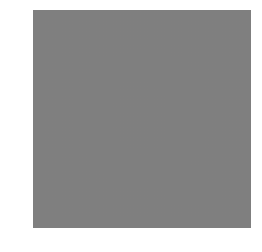

In [0]:
# netShapeM.G_S.load_state_dict(torch.load('../save/waterfall-GS.ckpt'))  
netShapeM.eval()
I = load_image('../data/rawtext/yaheiB/val/0801.png')
I = to_var(I[:,:,32:288,32:288])
result = netShapeM(I, 1)
visualize(to_data(result[0]))

# Generate Styled Glyphs
Finally, we can used the generated glyph composition as the input image, and get the waterfall version of it using ShapeMatchingGAN.

In [0]:
!python test.py \
--text_name /content/ShapeMatchingGAN/data/glyph_0_big.png \
--scale -1 --scale_step 0.2 \
--structure_model /content/ShapeMatchingGAN/save/waterfall-GS.ckpt \
--texture_model /content/ShapeMatchingGAN/save/waterfall-GT.ckpt \
--result_dir ../output --name waterfall_glyph \
--text_type 1 \
--gpu

--- load options ---
gpu: True
name: waterfall_glyph
result_dir: ../output
scale: -1.0
scale_step: 0.2
structure_model: /content/ShapeMatchingGAN/save/waterfall-GS.ckpt
text_name: /content/ShapeMatchingGAN/data/glyph_0_big.png
text_type: 1
texture_model: /content/ShapeMatchingGAN/save/waterfall-GT.ckpt
--- load data ---
--- load model ---
--- testing ---
--- save ---


In [0]:
 !python test.py \
--text_name /content/ShapeMatchingGAN/data/calligraphy.png \
--scale -1 --scale_step 0.05 \
--structure_model ../save/waterfall-GS.ckpt \
--texture_model ../save/waterfall-GT.ckpt \
--result_dir ../output --name waterfall \
--text_type 1 \
--gpu

--- load options ---
gpu: True
name: waterfall
result_dir: ../output
scale: -1.0
scale_step: 0.05
structure_model: ../save/waterfall-GS.ckpt
text_name: /content/ShapeMatchingGAN/data/calligraphy.png
text_type: 1
texture_model: ../save/waterfall-GT.ckpt
--- load data ---
--- load model ---
--- testing ---
--- save ---
